## **Interpretability via Attentional and Memory-based Interfaces Using TensorFlow**
#### A closer look at the reasoning inside your deep networks

**TLDR**: This post will serve as a gentle introduction to attentional and memory-based interfaces in deep neural architectures using TensorFlow. Incorporation of attention mechanisms is very simple and can improve transparency interpretability in our complex models. We will conclude with extensions and caveats of the interfaces. The intended audience for this notebook are developers and researchers who have some basic understanding of Tensorflow and fundamental deep learning concepts. Check out this [post](https://www.oreilly.com/learning/hello-tensorflow) for a nice introduction to Tensorflow.

### [Just take me to the model!](#7)

### **Table of Contents**
1. [Applying Selective Attention to Deep Learning
](#1)
2. [Overview of Attentional Interfaces](#2)
3. [Basic Sentiment Analysis and Overview Architecture](#3)
4. [Setup](#4)
5. [Preprocessing Components](#5)
6. [Sample the Data](#6)
7. [Model](#7)
7. [Training](#8)
9. [Results](#9)
10. [Attention for a Sample](#10)
11. [Attentional History](#11)
12. [Attentional Interface Variants](#12)
13. [Caveats](#13)
13. [Interpretability and why it’s important](#14)
14. [References](#15)
15. [Author Bio](#16)

<a id='1'></a>
### **I. Applying Selective Attention to Deep Learning**

Attentional interfaces in deep neural networks are loosely based on visual attention mechanisms, found in many animals. These mechanisms allow the organisms to dynamically focus on pertinent parts of a visual input, and respond accordingly. This basic idea of selective attention has been carried over to deep learning, where it is being used in image analysis, translation, question/answering, speech, and a variety of other tasks.

![](images/image_attn.jpg)
<center><b>Figure 1</b> Attention on an image for a specific (underlined) word in the caption.</center>
<center>[Kelvin Xu, Jimmy Ba, Ryan Kiros, Kyunghyun Cho, Aaron Courville, Ruslan Salakhutdinov, Richard Zemel: “Show, Attend and Tell: Neural Image Caption Generation with Visual Attention”.](http://arxiv.org/abs/1502.03044)</center>


These interfaces also offer much needed model interpretability, by allowing us to see which parts of the input is attended to at any point in time. A common disadvantage with deep neural architectures is the lack of interpretability and the associated "black box" stigma. Implementation of these interfaces has not only been shown to increase model performance, but also offer more transparent and sensible results. And as you will see in our implementation below, they produce some interesting visualizations that are consistent with how we would attend to the inputs.

![](images/nlu_attn.jpg)
<center><b>Figure 2</b> Attention heatmaps offering interpretability on where the model is looking to respond.</center>
<center>[Karl Moritz Hermann, Tomáš Kočiský, Edward Grefenstette, Lasse Espeholt, Will Kay, Mustafa Suleyman: “Teaching Machines to Read and Comprehend”.](http://arxiv.org/abs/1506.03340)</center>

Research on attentional interfaces is very popular these days, because offer multiple benefits. There are increasingly complex variants to the attention mechanisms, but the overall foundation remains the same. In this article, we will take a look at the fundamental attentional interface, implement it with a small model, and then discuss some recent variants. We will be using attention in Natural Language Understanding (NLU) tasks but will briefly explore other areas as well.

<a id='2'></a>
### **II. Overview of Attentional Interfaces**

First, let's take a closer look at the fundamental idea behind an attentional interface. 

The attention model takes in j inputs ($h_1, h_2, … h_j$), along with some information $s_{i-1}$ (memory), and outputs vector c, which is the summary of the hidden states focusing on the information $s_{i-1}$. Before we see what goes on internally, it is important to point out that there are a couple of different options for attention (i.e. soft, hard), but the type we will focus on will all be completely differentiable (ex. soft). This is because we want to be able to learn where to focus. This also means that we will be focusing everywhere at all times, but we will learn where to place more attention.

We can think of our $s_{i-1}$ as the generated context describing what we should focus on. We take the dot product of each input item within this context in order to produce a score. The scores (e from equations on figure 3) are fed into a softmax to create our attention distribution. We multiply these normalized scores with our original inputs to receive a weighted summary vector for timestep/input i.

![](images/soft.jpg)
<br><br>
<center><b>Figure 3 </b>Internal operations for making the summariazing vector c.</center>
<center>Credit: Goku Mohandas</center>

One of the main advantages of using an attentional interface is the opportunity to interpret and visualize the attention scores. We can see for each input, where the model places more attention, and how that impacts our final result. There are many ways to implement fully differential attentional interfaces, and the internal intricacies can differ. The example we have above is very commonly seen in neural translation models. 

With translation, we don’t want just one summarizing vector using all of the inputs -- we want a summarizing vector for each input. This is because translation is not always a one-to-one output. Words in one language may result in multiple words in another, so we need to attend to the entire sentence for all inputs, while using that context information so we know what we have seen so far.

We can go ahead and plot the attention scores for translation, and we will see something like Figure 4. Notice how some words, like "me", very clearly only need to attend to one word. But other words, or groups of words, require attention across multiple words from the source language in order to translate properly.


![](images/nmt.jpg)
<br><br>
<center><b>Figure 4 </b>Architecture and attention visualization for a basic neural machine translation task, such as translating between English and French.</center>
<center>Credit: Goku Mohandas</center>

<a id='3'></a>
### **III. Basic Sentiment Analysis and Overview Architecture**

We will be using a sentiment analysis task in order to implement a basic attentional interface. This simple use case will be a nice introduction to how we can add attention to existing models, for improved performance and interpretability. 

We will be using the Large Movie Review dataset, which contains 50,000 reviews that are split evenly into 25k train and 25k test sets. The dataset includes text reviews with ratings from 0-9, but we will use ratings 0-4 as positive and 5-9 as negative sentiment. More specifics, including unlabeled data for unsupervised learning, and data collection details are provided in the readme file contained in the [zipped dataset](https://github.com/ajarai/Attentional-Interfaces-O-Reilly/blob/master/data/processed_reviews.zip).

Here is the overview of the architecture, including the attentional interface. We will cover the details of preprocessing, the model, and the training procedure below. In Figure 5, you will notice how the attention layer is almost just like a pluggable interface. We could have just as easily taken the last (relevant) hidden state from the encoder and applied a nonlinearity, followed by normalization, to receive a predicted sentiment. Adding this attentional layer, however, gives us the chance to look inside the model, and gain interpretability from the inferences.

<img src="images/architecture.jpg" width="700">
<br><br>
<center><b>Figure 5 </b>Model architecture overview.</center>
<center>Credit: Goku Mohandas</center>

<a id='4'></a>
### **IV. Setup**
We will fetch all the data (trained embeddings, processed reviews, and trained model) by executing the commands detailed out in the [iPython notebook for this article](https://github.com/ajarai/Attentional-Interfaces-O-Reilly). We will be using preprocessed data, but for optimal inference performance, you could retrain the model from scratch, using all 25,000 training/test samples. The main focus of this article, however, is on attention mechanisms, and how you can add them to your networks for increased interpretability.

1. Download [this entire repo from GitHub](https://github.com/ajarai/O-Reilly)

2. Open your terminal and use `cd` to navigate into the top directory of the repo on your machine

3. Unzip the processed reviews data by entering the following inside the data directory. 
```bash
unzip processed_reviews.zip
```

Now, set up your environment by using the Dockerfile included with this repo (option A) or configuring it manually (option B).

#### Option A: use the Dockerfile configured for this notebook
(Note: For GPU versions, etc. check out [TensorFlow's Docker repo](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/docker).)

4. After downloading this repo to your machine, open your terminal and use `cd` to navigate to the directory that contains `Dockerfile.cpu`.

5. To build the Dockerfile, enter
```bash
docker build -t dockerfile_cpu -f dockerfile.cpu .
```
If you get a permissions error on running this command, you may need to run it with `sudo`:
```bash
sudo  build -t dockerfile_cpu -f dockerfile.cpu .
```

6. Run Docker from the Dockerfile you've just built
```bash
docker run -it -p 8888:8888 -p 6006:6006 dockerfile_cpu bash
```
or
```bash
sudo docker run -it -p 8888:8888 -p 6006:6006 dockerfile_cpu bash
```
if you run into permission problems.

7. Launch Jupyter by entering
```bash
jupyter notebook
```
and, using your browser, navigate to the URL shown in the terminal output (usually http://localhost:8888/)

#### Option B: set up environment manually on local machine
For instructions on installing TensorFlow, please see [TensorFlow's platform-specific installation instructions](https://www.tensorflow.org/install/).
```bash
Required:
python 3.3+
pip 9.0.1 (sudo easy_install pip)
virtualenv (pip install virtualenv)
Optional: CUDA enabled GPU (explicity define cpu components (embedding, etc.)
```

4. Enter the `attention` directory in your terminal and enter the following commands
```bash
make venv
source oreilly-attention-venv/bin/activate
make load-data
ipython3 notebook attention.ipynb
```
5. Launch Jupyter by entering
```bash
jupyter notebook
```
and, using your browser, navigate to the URL shown in the terminal output (usually http://localhost:8888/)


In [1]:
# Establish basedir (useful if running as python package)
import os
basedir = ""

In [2]:
# Hide all warning messages
import warnings
warnings.filterwarnings('ignore')

<a id='5'></a>
### **V. Preprocessing Components**

In this section, we will preprocess our raw input data. The main components are the Vocab class, which we initialize using our vocab.txt file. This file contains all of the tokens (words) from our raw input, sorted by descending frequency. The next helper function we need is ids_to_tokens(), which will convert a list of ids into tokens we can understand. We will use this for reading our input and associating the word with its respective attention score.

#### Processing Pipeline

In [3]:
"""
Preprocess the reviews.
"""
import argparse
import json
import os
import pickle
import re
import tensorflow as tf
import numpy as np

from unidecode import (
    unidecode,
)

from random import (
    shuffle,
)

from tqdm import (
    tqdm,
)

from collections import (
    Counter,
)

UNKNOWN_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'

In [4]:
class Vocab():
    """
    Class for processing tokens to ids and vice versa.
    """
    def __init__(self, vocab_file, max_vocab_size=200000, verbose=True):
        """
        """
        self.verbose = verbose
        self._token_to_id = {}
        self._id_to_token = {}
        self._size = -1

        with open(vocab_file, 'rt', encoding='utf-8') as f:
            for line in f:
                tokens = line.split()

                # White space in vocab file (' ': <count>)
                if len(tokens) == 1:
                    count = tokens[0]
                    idx = line.index(count)
                    t = line[:idx-1]
                    tokens = (t, count)

                if len(tokens) != 2:
                    continue

                if tokens[0] in self._token_to_id:
                    continue

                self._size += 1
                if self._size > max_vocab_size:
                    print ('Too many tokens! >%i/n' % max_vocab_size)
                    break

                self._token_to_id[tokens[0]] = self._size
                self._id_to_token[self._size] = tokens[0]

    def __len__(self):
        """
        Return vocabulary size.
        """
        return self._size+1

    def token_to_id(self, token):
        """
        Return the corresponding id for a token.
        """
        if token not in self._token_to_id:
            if self.verbose:
                print ("ID not found for %s" % token)
            return self._token_to_id[UNKNOWN_TOKEN]
        return self._token_to_id[token]

    def id_to_token(self, _id):
        """
        Returnn the correspoding token for an id.
        """
        if _id not in self._id_to_token:
            if self.verbose:
                print ("Token not found for ID: %i" % _id)
            return UNKNOWN_TOKEN
        return self._id_to_token[_id]

def ids_to_tokens(ids_list, vocab):
    """
    Convert a list of ids to tokens.
    Args:
        ids_list: list of ids to convert to tokens.
        vocab: Vocab class object.
    Returns:
        answer: list of tokens that corresponds to ids_list.
    """
    answer = []
    for _id in ids_list:
        token = vocab.id_to_token(_id)
        if token == PAD_TOKEN:
            continue
        answer.append(token)
    return answer

<a id='6'></a>
### **VI. Sample the data**

Now, we will see what our inputs will look like. The processed_review represents our reviews with ids. The `review_seq_len` tells us how long the review is. Unless we use dynamic computation graphs, we need to feed in fixed sized inputs into our TensorFlow models per batch. This means that we will have some padding (with `PAD`s) and we do not want these to influence our model. In this implementation, the PADs do not prove to be too problematic, since inference will depend on the entire summarized context (so no loss masking is needed). And we also want to keep the PAD tokens, even when determining the attention scores, to show how the model learns not to focus on the PADs over time.

In [5]:
"""
Utility functions
"""
import os
import argparse
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
class parameters():
    """
    Arguments for data processing.
    """
    def __init__(self):
        """
        """  
        self.data_dir="data/processed_reviews/train.p"           # location of reviews data (train|validation)

In [7]:
def sample_data(data_path):
    """
    Sample format of the processed
    data from data.py
    Args:
        data_path: path for train.p|valid.p
    """
    with open(data_path, 'rb') as f:
        entries = pickle.load(f)

    # Choose a random sample
    rand_index = random.randint(0, len(entries))

    # Prepare vocab
    vocab_file = os.path.join(basedir, 'data/processed_reviews/vocab.txt')
    vocab = Vocab(vocab_file, verbose=False)

    # Sample
    (processed_review,
     review_seq_len,
     label) = entries[rand_index]

    print ("==> Number of entries:", len(entries))
    print ("==> Random index:", rand_index)
    print ("==> Processed Review:", processed_review)
    print ("==> Review Len:", review_seq_len)
    print ("==> Label:", label)
    print ("==> See if processed review makes sense:",
        ids_to_tokens(
            processed_review,
            vocab=vocab,
            ))

In [8]:
FLAGS = parameters()
sample_data(FLAGS.data_dir)

==> Number of entries: 5593
==> Random index: 1236
==> Processed Review: [263, 31, 118, 2, 951, 116, 13, 2, 2335, 7, 2586, 109, 4, 14, 18, 6, 126, 5552, 8, 115, 2, 2586, 6599, 3, 11, 11, 197, 12, 18, 6, 64, 3022, 583, 5, 14, 83, 30, 9, 27, 35, 2, 442, 7, 31, 1906, 57, 18, 1448, 684, 8, 31, 324, 2, 96, 116, 117, 3, 261, 179, 7, 2, 72, 18, 765, 8, 395, 5, 14, 1576, 13, 125, 21, 2, 2586, 6599, 168, 12, 75, 3841, 2, 17737, 38, 14, 52, 30, 9, 27, 112, 14, 35, 133, 300, 149, 43, 12378, 102, 4, 5, 3125, 24, 4, 265, 43, 210, 24, 3, 241, 14, 629, 3592, 251, 46, 210, 5, 699, 552, 109, 4, 15, 18, 149, 97, 1629, 8, 81, 3, 6599, 10, 37, 7, 2, 101, 8450, 117, 4, 12, 5144, 137, 688, 46, 2, 96, 338, 2363, 2, 239, 780, 168, 2, 888, 1606, 3, 11, 11, 2271, 4756, 18, 336, 769, 19, 34, 221, 19, 1632, 2586, 3, 14, 9, 147, 558, 6, 181, 53, 34, 97, 361, 13, 2, 2586, 301, 244, 4, 5, 157, 4, 15, 2738, 278, 54, 37, 61, 8, 760, 8, 34, 1011, 3, 14, 174, 918, 8, 324, 61, 7, 34, 109, 13, 2, 691, 3, 11, 11, 2, 3322, 

<a id='7'></a>
### **VII. Model**

We will start by talking about operation functions. `_xavier_weight_init()` is a little function we made to properly initialize our weights, depending on the nonlinearity that will be applied to them. The initialization is such that we will receive outputs with unit variance prior to sending to the activation function. 

This is an optimization technique we use so that we do not have large values when applying the nonlinearity, as that will lead to saturation at the extremes and lead to gradient issues. We also have a helper function for layer normalization, `ln()`, which is another optimization technique that will normalize our inputs into the GRU (Gated Recurrent Unit) before applying the activation function. This will allow us to control gradient issues and even allow us to use larger learning rates. The layer normalization is applied in the `custom_GRU()` function prior to the sigmoid and tanh operations. The last helper function is `add_dropout_and_layers()` which will add dropout to our recurrent outputs and will allow us to create multi-layered recurrent architectures.

#### Operation functions

In [9]:
"""
Operation functions for model.py
"""
import tensorflow as tf
import numpy as np

from tensorflow.contrib.layers.python.layers import (
    utils,
)

from tensorflow.python.framework import (
    ops,
    tensor_shape,
)

from tensorflow.python.ops import (
        gen_array_ops,
        array_ops,
        clip_ops,
        embedding_ops,
        init_ops,
        math_ops,
        nn_ops,
        partitioned_variables,
        variable_scope as vs,
)

from tensorflow.python.ops.math_ops import (
        sigmoid,
        tanh,
)

from tensorflow.python.util import (
    nest,
)

def _xavier_weight_init(nonlinearity='tanh'):
    """
    Xavier weights initialization.
    """
    def _xavier_initializer(shape, **kwargs):
        """
        Tanh and sigmoid initialization.
        """
        eps = 1.0 / np.sqrt(np.sum(shape))
        return tf.random_uniform(shape, minval=-eps, maxval=eps)

    def _relu_xavier_initializer(shape, **kwargs):
        """
        ReLU initialization.
        """
        eps = np.sqrt(2.0) / np.sqrt(np.sum(shape))
        return tf.random_uniform(shape, minval=-eps, maxval=eps)

    if nonlinearity in ('tanh', 'sigmoid'):
        return _xavier_initializer
    elif nonlinearity in ('relu'):
        return _relu_xavier_initializer
    else:
        raise Exception(
            "Please choose a valid nonlinearity: tanh|sigmoid|relu")

def _linear(args, output_size, bias, bias_start=0.0,
    nonlinearity='relu', scope=None, name=None):
    """
    Sending inputs through a two layer MLP.
    Args:
        args: list of inputs of shape (N, H)
        output_size: second dimension of W
        bias: boolean, whether or not to add bias
        bias_start: initial bias value
        nonlinearity: nonlinear transformation to use (tanh|sigmoid|relu)
        scope: (optional) Variable scope to create parameters in.
        name: (optional) variable name.
    Returns:
        Tensor with shape (N, output_size)
    """
    _input = tf.concat(
        values=args,
        axis=1,)
    shape = _input.get_shape()
    # Computation
    scope = vs.get_variable_scope()
    with vs.variable_scope(scope) as outer_scope:
        w_name = "W_1_"
        if name is not None:
            w_name += name
        W_1 = vs.get_variable(
            name=w_name,
            shape=[shape[1], output_size],
            initializer=_xavier_weight_init(
                nonlinearity=nonlinearity),
            )
        result_1 = tf.matmul(_input, W_1)
        if bias:
            b_name = "b_1_"
            if name is not None:
                b_name += name
            b_1 = vs.get_variable(
                name=b_name,
                shape=(output_size,),
                initializer=init_ops.constant_initializer(
                    bias_start, dtype=tf.float32),
                )
            result_1 = tf.add(result_1, b_1)
    return result_1

def ln(inputs, epsilon=1e-5, scope=None):

    """ Computer layer norm given an input tensor. We get in an input of shape
    [N X D] and with LN we compute the mean and var for each individual
    training point across all it's hidden dimensions rather than across
    the training batch as we do in BN. This gives us a mean and var of shape
    [N X 1].
    """
    mean, var = tf.nn.moments(inputs, [1], keep_dims=True)
    with tf.variable_scope(scope + 'LN'):
            scale = tf.get_variable('alpha',
                shape=[inputs.get_shape()[1]],
                initializer=tf.constant_initializer(1))
            shift = tf.get_variable('beta',
                shape=[inputs.get_shape()[1]],
                initializer=tf.constant_initializer(0))
    LN = scale * (inputs - mean) / tf.sqrt(var + epsilon) + shift

    return LN

class custom_GRUCell(tf.contrib.rnn.RNNCell):
        """Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078)."""

        def __init__(self, num_units, input_size=None, activation=tanh):
            if input_size is not None:
                logging.warn("%s: The input_size parameter is deprecated.", self)
            self._num_units = num_units
            self._activation = activation

        @property
        def state_size(self):
            return self._num_units

        @property
        def output_size(self):
            return self._num_units

        def __call__(self, inputs, state, scope=None):
            """Gated recurrent unit (GRU) with nunits cells."""
            with vs.variable_scope(scope or type(self).__name__):  # "GRUCell"
                with vs.variable_scope("Gates"):  # Reset gate and update gate.
                    # We start with bias of 1.0 to not reset and not update.
                    r, u = array_ops.split(
                            _linear([inputs, state], 2 * self._num_units, True, 1.0), 2, 1,
                    )

                    # Apply Layer Normalization to the two gates
                    r = ln(r, scope = 'r/')
                    u = ln(r, scope = 'u/')

                    r, u = sigmoid(r), sigmoid(u)
                with vs.variable_scope("Candidate"):
                    c = self._activation(
                        _linear([inputs, r * state],
                            self._num_units, True))
                new_h = u * state + (1 - u) * c
            return new_h, new_h

def add_dropout_and_layers(single_cell, keep_prob, num_layers):
    """
    Add dropout and create stacked layers using a single_cell.
    """

    # Dropout
    stacked_cell = tf.contrib.rnn.DropoutWrapper(single_cell,
        output_keep_prob=keep_prob)

    # Each state as one cell
    if num_layers > 1:
        stacked_cell = tf.nn.rnn_cell.MultiRNNCell(
            [single_cell] * num_layers)

    return stacked_cell

Let's briefly describe the model pipelines and see how our inputs undergo representation changes. First we will initialize our placeholders which will hold the reviews, lens, sentiment, embeddings etc. Then we will build the encoder which will take our input review and first embed using the GloVe embeddings. We will then feed the embedded tokens into a GRU in order to encode the input. We will use the output from each timestep in the GRU as our inputs to the attentional layer. Notice that we could have completely removed the attentional interface, and just used the last relevant hidden state from the encoder GRU in order to receive our predicted sentiment, but -- adding this attention layer allows us to see how the model processes the input review.

In the attentional layer, we apply a nonlinearity followed by another one, in order to reduce our representation to one dimension. Now, we can normalize to compute our attention scores. These scores are then broadcasted and multiplied with the original inputs to receive our summarized vector. We use this vector to receive our predicted sentiment via normalization in the decoder. Notice that we do not use a previous state ($s_{i-1}$) since the task involves creating just one context and extracting the sentiment from that.

We then define our loss as the cross entropy between the predicted and the ground truth sentiment. We use a bit of decay for our learning rate with an absolute minimum and use the ADAM optimizer [9]. With all of these components, we have built our graph.

In [10]:
"""
Simple GRU Encoder/Decoder Model w/ Attentional Interface
"""
import tensorflow as tf
import numpy as np

class Model():
    """
    Tensorflow graph.
    """
    def __init__(self, FLAGS, vocab_size):
        """
        """
        self.FLAGS = FLAGS
        self._vsize = vocab_size

    def train(self, sess, batch_reviews, batch_labels,
        batch_review_lens, embeddings, keep_prob):
        """
        Train the model using a batch and predicted guesses.
        """
        outputs = [
            self._train_op,
            self._logits,
            self._loss,
            self._accuracy,
            self._lr,
            self._Z,
                   ]
        inputs = {
            self._reviews: batch_reviews,
            self._labels: batch_labels,
            self._review_lens: batch_review_lens,
            self._embeddings: embeddings,
            self._keep_prob: keep_prob,
                  }
        return sess.run(outputs, inputs)

    def eval(self, sess, batch_reviews, batch_labels,
        batch_review_lens, embeddings, keep_prob=1.0):
        """
        Evaluation of validation set.
        """
        outputs = [
            self._logits,
            self._loss,
            self._accuracy,
        ]
        inputs = {
            self._reviews: batch_reviews,
            self._labels: batch_labels,
            self._review_lens: batch_review_lens,
            self._embeddings: embeddings,
            self._keep_prob: keep_prob,
            }
        return sess.run(outputs, inputs)

    def infer(self, sess, batch_reviews,
        batch_review_lens, embeddings, keep_prob=1.0):
        """
        Inference with a sample sentence.
        """
        outputs = [
            self._logits,
            self._probabilities,
            self._Z,
        ]
        inputs = {
            self._reviews: batch_reviews,
            self._review_lens: batch_review_lens,
            self._embeddings: embeddings,
            self._keep_prob: keep_prob,
            }
        return sess.run(outputs, inputs)

    def _add_placeholders(self):
        """
        Input that will be fed into our DCN graph.
        """
        print ("==> Adding placeholders:")

        FLAGS = self.FLAGS
        self._reviews = tf.placeholder(
            dtype=tf.int32,
            shape=[None, FLAGS.max_input_length],
            name="reviews")
        self._review_lens = tf.placeholder(
            dtype=tf.int32,
            shape=[None, ],
            name="review_lens")
        self._labels = tf.placeholder(
            dtype=tf.int32,
            shape=[None,],
            name="labels")
        self._embeddings = tf.placeholder(
            dtype=tf.float32,
            shape=(FLAGS.vocab_size, FLAGS.emb_size),
            name='glove_embeddings')
        self._keep_prob = tf.placeholder(
            dtype=tf.float32,
            shape=(),
            name="keep_prob")

        print ("\t self._reviews:", self._reviews.get_shape())
        print ("\t self._labels:", self._labels.get_shape())
        print ("\t self._embeddings:", self._embeddings.get_shape())
        print ("\t self._keep_prob:", self._keep_prob.get_shape())

    def _build_encoder(self):
        """
        Constructing the encoder.
        """
        print ("==> Building the encoder:")

        FLAGS = self.FLAGS
        batch_size = FLAGS.batch_size
        hidden_size = FLAGS.hidden_size
        max_input_length = FLAGS.max_input_length

        with tf.variable_scope('embedding'):
            print ("\t embedding:")

            if FLAGS.embedding == 'random':
                # Random embedding weights
                embedding = tf.get_variable(
                    name='embedding',
                    shape=[self._vsize, FLAGS.emb_size],
                    dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=1e-4),
                    trainable=FLAGS.train_embedding)
            elif FLAGS.embedding == 'glove':
                # GloVe embedding weights
                embedding = self._embeddings

            # Check embedding dim
            if embedding.get_shape()[1] != FLAGS.emb_size:
                raise Exception(
                    "Embedding's dimension does not match specified emb_size.")

            # Embedding the review
            fn = lambda x: tf.nn.embedding_lookup(embedding, x)
            c_embedding = tf.map_fn(
                lambda x: fn(x), self._reviews, dtype=tf.float32)

            print ("\t\t embedding:", embedding.get_shape())
            print ("\t\t reviews_embedded:", c_embedding.get_shape())

        with tf.variable_scope('c_encoding'):
            print ("\t c_encoding:")

            # GRU cells
            cell = add_dropout_and_layers(
                single_cell=custom_GRUCell(hidden_size),
                keep_prob=self._keep_prob,
                num_layers=FLAGS.num_layers,
                )

            # Dynamic-GRU
            # return (outputs, last_output_states (relevant))
            all_outputs, h = tf.nn.dynamic_rnn(
                cell=cell,
                inputs=c_embedding,
                #sequence_length=self._review_lens,
                dtype=tf.float32,
                time_major=False,
                )

            self._all_outputs = all_outputs
            self._h = h

            self._z = all_outputs

            print ("\t\t self._all_outputs", self._all_outputs.get_shape())
            print ("\t\t self._h", self._h.get_shape())

    def _build_attentional_interface(self):
        """
        Adding an attentional interface
        for model interpretability.
        """
        print ("==> Building the attentional interface:")

        FLAGS = self.FLAGS
        batch_size = FLAGS.batch_size
        hidden_size = FLAGS.hidden_size
        max_input_length = FLAGS.max_input_length
        loop_until = tf.to_int32(np.array(range(batch_size)))

        with tf.variable_scope('attention') as attn_scope:
            print ("\t attention:")

            # Time-major self._all_outputs (N, M, H) --> (M, N, H)
            all_outputs_time_major = tf.transpose(self._all_outputs,
                perm=[1,0,2])

            # Apply tanh nonlinearity
            fn = lambda _input: tf.nn.tanh(_linear(
                    args=_input,
                    output_size=hidden_size,
                    bias=True,
                    bias_start=0.0,
                    nonlinearity='tanh',
                    scope=attn_scope,
                    name='attn_nonlinearity',
                    ))
            z = tf.map_fn(
                lambda x: fn(x), all_outputs_time_major, dtype=tf.float32)

            # Apply softmax weights
            fn = lambda _input: tf.nn.tanh(_linear(
                    args=_input,
                    output_size=1,
                    bias=True,
                    bias_start=0.0,
                    nonlinearity='tanh',
                    scope=attn_scope,
                    name='attn_softmax',
                    ))
            z = tf.map_fn(
                lambda x: fn(x), z, dtype=tf.float32)

            # Squeeze and convert to batch major
            z = tf.transpose(
                    tf.squeeze(
                        input=z,
                        axis=2,
                        ),
                    perm=[1,0])

            # Normalize
            self._Z = tf.nn.softmax(
                logits=z,
                )

            # Create context vector (via soft attention.)
            fn = lambda sample_num: \
                tf.reduce_sum(
                    tf.multiply(
                        self._all_outputs[sample_num][:self._review_lens[sample_num]],

                        # (500,) --> (500, 1) --> (500, 200)
                        tf.tile(
                            input=tf.expand_dims(
                                self._Z[sample_num][:self._review_lens[sample_num]], 1),
                            multiples=(1, hidden_size),
                        )),
                    axis=0)

            self._c = tf.map_fn(
                lambda sample_num: fn(sample_num), loop_until, dtype=tf.float32)

            print ("\t\t self._Z", self._Z.get_shape())
            print ("\t\t self._c", self._c.get_shape())

    def _build_decoder(self):
        """
        Applying a softmax on output of encoder.
        """
        print ("==> Building the decoder:")
        with tf.variable_scope('softmax'):
            print ("\t Softmax:")
            self._logits = _linear(
                args=self._c, # self._c (with attn) or self._h (no attn)
                output_size=self.FLAGS.num_classes,
                bias=True,
                bias_start=0.0,
                nonlinearity='relu',
                name='softmax_op',
                )
            self._probabilities = tf.nn.softmax(
                logits=self._logits,
                )
            print ("\t\t self._logits", self._logits.get_shape())
            print ("\t\t self._probabilities", self._probabilities.get_shape())

    def _add_loss(self):
        """
        Determine the loss.
        """
        print ("==> Establishing the loss function.")
        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=self._labels, logits=self._logits))
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self._logits, 1),
            tf.cast(self._labels, tf.int64)), tf.float32))
        return self.loss, self.accuracy

    def _add_train_op(self):
        """
        Add the training optimizer.
        """
        print ("==> Creating the training optimizer.")

        # Decay learning rate
        self._lr = tf.maximum(
            self.FLAGS.min_lr,
            tf.train.exponential_decay(
                learning_rate=self.FLAGS.lr,
                global_step=self.global_step,
                decay_steps=100000,
                decay_rate=self.FLAGS.decay_rate,
                staircase=False,
                ))

        # Training releaved no clipping needed

        # Initialize the optimizer
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self._lr).minimize(self.loss,
            global_step=self.global_step)
        return self.optimizer

    def _build_graph(self):
        """
        Contrust each component of the TF graph.
        """
        self._add_placeholders()
        self._build_encoder()
        self._build_attentional_interface()
        self._build_decoder()

        self.global_step = tf.Variable(0, trainable=False) # won't step
        if self.FLAGS.mode == 'train':
            self._loss, self._accuracy = self._add_loss()
            self._train_op = self._add_train_op()

        # Components for model saving
        self.saver = tf.train.Saver(tf.global_variables())
        print ("==> Review Classifier built!")

<a id='8'></a>
### **VIII. Training**

#### Helper functions

In [11]:
def generate_epoch(data_path, num_epochs, batch_size):
    """
    Generate num_epoch epochs.
    Args:
        data_path: path for train.p|valid.p
        num_epochs: number of epochs to run for
        batch_size: samples per each batch
    """
    with open(data_path, 'rb') as f:
        entries = pickle.load(f)

    processed_contexts, processed_answers = [], []
    context_lens = []

    for entry in entries:
        processed_contexts.append(entry[0])
        context_lens.append(entry[1])
        processed_answers.append(entry[2])

    features = [processed_contexts, processed_answers]
    seq_lens = [context_lens,]

    for epoch_num in range(num_epochs):
        yield generate_batch(features, seq_lens, batch_size)

In [12]:
def generate_batch(features, seq_lens, batch_size):
    """
    Generate batches of size <batch_size>.
    Args:
        features: processed contexts, questions and answers.
        seq_lens: context and question actual (pre-padding) seq-lens.
        batch_size: samples per each batch
    """
    data_size = len(features[0])
    num_batches = data_size//batch_size

    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num+1)*batch_size, data_size)

        batch_features = []
        for feature in features:
            batch_features.append(feature[start_index:end_index])
        batch_lens = []
        for seq_len in seq_lens:
            batch_lens.append(seq_len[start_index:end_index])

        yield batch_features, batch_lens

In [13]:
class parameters():
    """
    Arguments for data processing.
    """
    def __init__(self):
        """
        """  
        self.data_dir="data/processed_reviews"           # location of reviews data
        self.ckpt_dir="data/processed_reviews/ckpt"      # location of model checkpoints
        self.mode="train"                                # train|infer
        self.model="new"                                 # old|new
        self.lr=1e-4                                     # learning rate
        self.num_epochs=4                               # num of epochs 
        self.batch_size=256                              # batch size
        self.hidden_size=200                             # num hidden units for RNN
        self.embedding="glove"                           # random|glove
        self.emb_size=200                                # num hidden units for embeddings
        self.max_grad_norm=5                             # max gradient norm
        self.keep_prob=0.9                               # Keep prob for dropout layers
        self.num_layers=1                                # number of layers for recurrsion
        self.max_input_length=300                        # max number of words per review
        self.min_lr=1e-6                                 # minimum learning rate
        self.decay_rate=0.96                             # Decay rate for lr per global step (train batch)
        self.save_every=10                               # Save the model every <save_every> epochs
        self.model_name="imdb_model"                    # Name of the model

In [14]:
def create_model(sess, FLAGS, vocab_size):
    """
    Creates a new model or loads old one.
    """
    imdb_model = Model(FLAGS, vocab_size)
    imdb_model._build_graph()

    if FLAGS.model == 'new':
        print ('==> Created a new model.')
        sess.run(tf.global_variables_initializer())
    elif FLAGS.model == 'old':
        ckpt = tf.train.get_checkpoint_state(
            os.path.join(basedir, FLAGS.ckpt_dir))
        if ckpt and ckpt.model_checkpoint_path:
            print("==> Restoring old model parameters from %s" %
                ckpt.model_checkpoint_path)
            imdb_model.saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            print ("==> No old model to load from so initializing a new one.")
            sess.run(tf.global_variables_initializer())

    return imdb_model

In [15]:
def train(FLAGS):
    """
    Train a previous or new model.
    """
    # Data paths
    vocab_path = os.path.join(
        basedir, 'data/processed_reviews/vocab.txt')
    train_data_path = os.path.join(
        basedir, 'data/processed_reviews/train.p')
    validation_data_path = os.path.join(
        basedir, 'data/processed_reviews/validation.p')
    vocab = Vocab(vocab_path)
    FLAGS.num_classes = 2

    # Load embeddings (if using GloVe)
    if FLAGS.embedding == 'glove':
        with open(os.path.join(
            basedir, 'data/processed_reviews/embeddings.p'), 'rb') as f:
            embeddings = pickle.load(f)
        FLAGS.vocab_size = len(embeddings)

    # Start tensorflow session
    with tf.Session() as sess:

        # Create|reload model
        imdb_model = create_model(sess, FLAGS, len(vocab))

        # Metrics
        metrics = {
            "train_loss": [],
            "valid_loss": [],
            "train_acc": [],
            "valid_acc": [],
        }

        # Store attention score history for few samples
        attn_history = {
            "sample_0":
            {"review": None, "label": None, "review_len": None, "attn_scores": []},
            "sample_1":
            {"review": None, "label": None, "review_len": None, "attn_scores": []},
            "sample_2":
            {"review": None, "label": None, "review_len": None, "attn_scores": []},
            "sample_3":
            {"review": None, "label": None, "review_len": None, "attn_scores": []},
            "sample_4":
            {"review": None, "label": None, "review_len": None, "attn_scores": []},
        }

        # Start training
        for train_epoch_num, train_epoch in \
            enumerate(generate_epoch(
                train_data_path, FLAGS.num_epochs, FLAGS.batch_size)):

            print ("==> EPOCH:", train_epoch_num)

            for train_batch_num, (batch_features, batch_seq_lens) in \
                enumerate(train_epoch):

                batch_reviews, batch_labels = batch_features
                batch_review_lens, = batch_seq_lens

                # Display shapes once
                if (train_epoch_num == 0 and train_batch_num == 0):
                    print ("Reviews: ", np.shape(batch_reviews))
                    print ("Labels: ", np.shape(batch_labels))
                    print ("Review lens: ", np.shape(batch_review_lens))

                _, train_logits, train_loss, train_acc, lr, attn_scores = \
                    imdb_model.train(
                        sess=sess,
                        batch_reviews=batch_reviews,
                        batch_labels=batch_labels,
                        batch_review_lens=batch_review_lens,
                        embeddings=embeddings,
                        keep_prob=FLAGS.keep_prob,
                        )

            for valid_epoch_num, valid_epoch in \
                enumerate(generate_epoch(
                    data_path=validation_data_path,
                    num_epochs=1,
                    batch_size=FLAGS.batch_size,
                    )):

                for valid_batch_num, (valid_batch_features, valid_batch_seq_lens) in \
                    enumerate(valid_epoch):

                    valid_batch_reviews, valid_batch_labels = valid_batch_features
                    valid_batch_review_lens, = valid_batch_seq_lens

                    valid_logits, valid_loss, valid_acc = imdb_model.eval(
                        sess=sess,
                        batch_reviews=valid_batch_reviews,
                        batch_labels=valid_batch_labels,
                        batch_review_lens=valid_batch_review_lens,
                        embeddings=embeddings,
                        keep_prob=1.0, # no dropout for val|test
                        )

            print ("[EPOCH]: %i, [LR]: %.6e, [TRAIN ACC]: %.3f, [VALID ACC]: %.3f " \
                   "[TRAIN LOSS]: %.6f, [VALID LOSS]: %.6f" % (
                train_epoch_num, lr, train_acc, valid_acc, train_loss, valid_loss))

            # Store the metrics
            metrics["train_loss"].append(train_loss)
            metrics["valid_loss"].append(valid_loss)
            metrics["train_acc"].append(train_acc)
            metrics["valid_acc"].append(valid_acc)

            # Store attn history
            for i in range(5):
                sample = "sample_%i"%i
                attn_history[sample]["review"] = batch_reviews[i]
                attn_history[sample]["label"] = batch_labels[i]
                attn_history[sample]["review_len"] = batch_review_lens[i]
                attn_history[sample]["attn_scores"].append(attn_scores[i])

            # Save the model (maybe)
            if ((train_epoch_num == (FLAGS.num_epochs-1)) or
            ((train_epoch_num%FLAGS.save_every == 0) and (train_epoch_num>0))):

                # Make parents ckpt dir if it does not exist
                if not os.path.isdir(os.path.join(basedir, FLAGS.data_dir, 'ckpt')):
                    os.makedirs(os.path.join(basedir, FLAGS.data_dir, 'ckpt'))

                # Make child ckpt dir for this specific model
                if not os.path.isdir(os.path.join(basedir, FLAGS.ckpt_dir)):
                    os.makedirs(os.path.join(basedir, FLAGS.ckpt_dir))

                checkpoint_path = \
                    os.path.join(
                        basedir, FLAGS.ckpt_dir, "%s.ckpt" % FLAGS.model_name)

                print ("==> Saving the model.")
                imdb_model.saver.save(sess, checkpoint_path,
                                 global_step=imdb_model.global_step)

    # Save the metrics
    metrics_file = os.path.join(basedir, FLAGS.ckpt_dir, 'metrics.p')
    with open(metrics_file, 'wb') as f:
        pickle.dump(metrics, f)

    # Save the attention scores
    attn_history_file = os.path.join(basedir, FLAGS.ckpt_dir, 'attn_history.p')
    with open(attn_history_file, 'wb') as f:
        pickle.dump(attn_history, f)

In [16]:
import time
start_time = time.time()

FLAGS = parameters()
train(FLAGS)

print("--- %s seconds ---" % (time.time() - start_time))

==> Adding placeholders:
	 self._reviews: (?, 300)
	 self._labels: (?,)
	 self._embeddings: (75133, 200)
	 self._keep_prob: ()
==> Building the encoder:
	 embedding:
		 embedding: (75133, 200)
		 reviews_embedded: (?, 300, 200)
	 c_encoding:
		 self._all_outputs (?, 300, 200)
		 self._h (?, 200)
==> Building the attentional interface:
	 attention:
		 self._Z (?, 300)
		 self._c (256, 200)
==> Building the decoder:
	 Softmax:
		 self._logits (256, 2)
		 self._probabilities (256, 2)
==> Establishing the loss function.
==> Creating the training optimizer.
==> Review Classifier built!
==> Created a new model.
==> EPOCH: 0
Reviews:  (256, 300)
Labels:  (256,)
Review lens:  (256,)
[EPOCH]: 0, [LR]: 9.999918e-05, [TRAIN ACC]: 0.547, [VALID ACC]: 0.465 [TRAIN LOSS]: 0.684365, [VALID LOSS]: 0.692204
==> EPOCH: 1
[EPOCH]: 1, [LR]: 9.999832e-05, [TRAIN ACC]: 0.688, [VALID ACC]: 0.578 [TRAIN LOSS]: 0.671597, [VALID LOSS]: 0.682623
==> EPOCH: 2
[EPOCH]: 2, [LR]: 9.999747e-05, [TRAIN ACC]: 0.711, [V

<a id='9'></a>
### **IX. Results**

In [17]:
class parameters():
    """
    Arguments for data processing.
    """
    def __init__(self):
        """
        """
        self.ckpt_dir="data/processed_reviews/ckpt"      # location of model checkpoints
        self.model_name="imdb_model"                     # Name of the model

In [18]:
def plot_metrics(FLAGS):
    """
    Plot the loss and accuracy for train|test.
    """
    import seaborn as sns

    # Load metrics from file
    metrics_file = os.path.join(basedir, FLAGS.ckpt_dir, 'metrics.p')
    with open(metrics_file, 'rb') as f:
        metrics = pickle.load(f)
        
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot results
    ax1 = axes[0]
    ax1.plot(metrics["train_acc"], label='train accuracy')
    ax1.plot(metrics["valid_acc"], label='valid accuracy')
    ax1.legend(loc=4)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('train|valid accuracy')

    ax2 = axes[1]
    ax2.plot(metrics["train_loss"], label='train loss')
    ax2.plot(metrics["valid_loss"], label='valid loss')
    ax2.legend(loc=3)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('train|valid loss')
    
    plt.show()

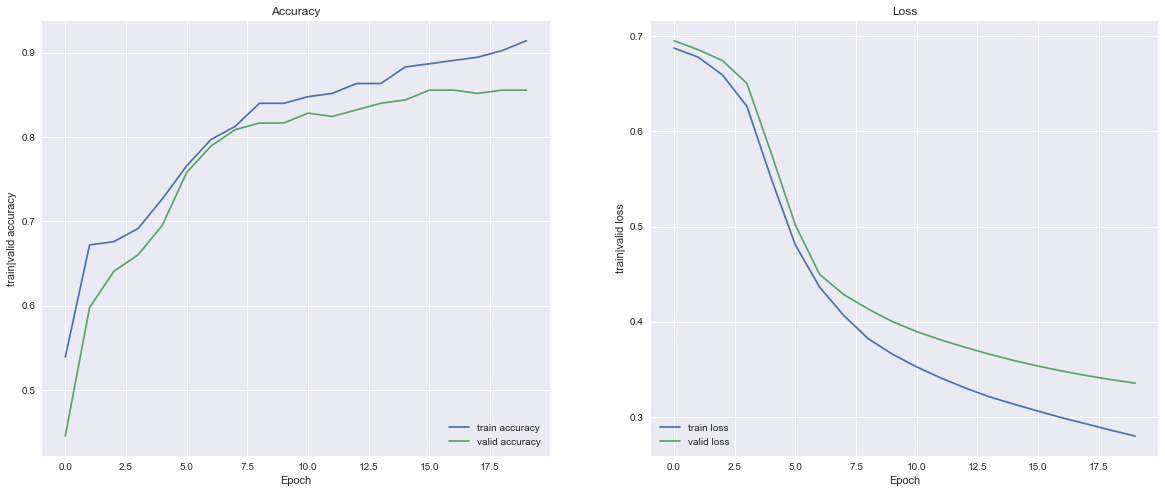

In [19]:
FLAGS = parameters()
# Add model name to ckpt dir
FLAGS.ckpt_dir = FLAGS.ckpt_dir + '/%s'%(FLAGS.model_name)
plot_metrics(FLAGS)

We can see a bit of overfitting after ~epoch 7. If you want to achieve the best performance, use all 25,000 training/test samples and include a lot more stringent regularization along with gradient clipping a more rigorous decay. But since just wanted to see some interpretable attention scores, this performance was satifactory.

<a id='10'></a>
### **X. Attention for a Sample**

In [20]:
import argparse
import os
import tensorflow as tf
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

from tqdm import (
    tqdm,
)

In [21]:
class parameters():
    """
    Arguments for data processing.
    """
    def __init__(self):
        """
        """
        self.data_dir="data/processed_reviews"           # location of reviews data
        self.ckpt_dir="data/processed_reviews/ckpt"      # location of model checkpoints
        self.model_name="imdb_model"                     # Name of the model
        self.sample_num=2                                # Sample num to view attn plot. [0-4]
        self.num_rows=5                                  # Number of rows to show in attn visualization.

In [22]:
def plot_attn(input_sentence, attentions, num_rows, save_loc=None):
    """
    Plot the attention scores.
    Args:
        input_sentence: input sentence (tokens) without <pad>
        attentions: attention scores for each token in input_sentence
        num_rows: how many rows you want the figure to have (we will add 1)
        save_loc: fig will be saved to this location
    """

    # Determine how many words per row
    words_per_row = (len(input_sentence.split(' '))//num_rows)

    # Use one extra row in case of remained for quotient above
    fig, axes = plt.subplots(nrows=num_rows+1, ncols=1, figsize=(20, 10))
    for row_num, ax in enumerate(axes.flat):

        # Isolate pertinent part of sentence and attention scores
        start_index = row_num*words_per_row
        end_index = (row_num*words_per_row)+words_per_row
        _input_sentence = \
            input_sentence.split(' ')[start_index:end_index]
        _attentions = np.reshape(
            attentions[0, start_index:end_index],
            (1, len(attentions[0, start_index:end_index]))
            )

        # Plot attn scores (constrained to [0.9, 1] for emphasis)
        im = ax.imshow(_attentions, cmap='Blues', vmin=0.9, vmax=1)

        # Set up axes
        ax.set_xticklabels(
            [''] + _input_sentence,
            rotation=90,
            minor=False,
            )
        ax.set_yticklabels([''])

        # Set x tick to top
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', colors='black')

        # Show corresponding words at the ticks
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add color bar
    fig.subplots_adjust(right=0.8)
    cbar = fig.add_axes([0.85, 0.15, 0.03, 0.7])

    # display color bar
    cb = fig.colorbar(im, cax=cbar)
    cb.set_ticks([]) # clean color bar

    if save_loc is None:
        # Show the plot
        plt.show()
    else:
        # Save the plot
        fig.savefig(save_loc, dpi=fig.dpi, bbox_inches='tight') # dpi=fig.dpi for high res. save

In [23]:
def get_attn_inputs(FLAGS, review, review_len, raw_attn_scores):
    """
    Return the inputs needed to
    plot the attn scores. These include
    input_sentence and attn_scores.
    Args:
        FLAGS: parameters
        review: list of ids
        review_len: len of the relevant review
    Return:
        input_sentence: inputs as tokens (words) on len <review_len>
        plot_attn_scoes: (1, review_len) shaped scores
    """

    review_len = 300

    # Data paths
    vocab_path = os.path.join(
        basedir, 'data/processed_reviews/vocab.txt')
    vocab = Vocab(vocab_path)

    review = review[:review_len]
    attn_scores = raw_attn_scores[:review_len]

    # Process input_sentence
    input_sentence = ' '.join([item for item in ids_to_tokens(review, vocab)])

    # Process attn scores (normalize scores between [0,1])
    min_attn_score = min(attn_scores)
    max_attn_score = max(attn_scores)
    normalized_attn_scores = ((attn_scores - min_attn_score) / \
        (max_attn_score - min_attn_score))

    # Reshape attn scores for plotting
    plot_attn_scores = np.zeros((1, review_len))
    for i, score in enumerate(normalized_attn_scores):
        plot_attn_scores[0, i] = score

    return input_sentence, plot_attn_scores

In [24]:
def process_sample_attn(FLAGS):
    """
    Use plot_attn from utils.py to visualize
    the attention scores for a particular
    sample FLAGS.sample_num.
    """

    # Load the attn history
    attn_history_path = os.path.join(
        basedir, FLAGS.ckpt_dir, 'attn_history.p')
    with open(attn_history_path, 'rb') as f:
        attn_history = pickle.load(f)

    # Process the history to get the right sample
    sample = "sample_%i" % (FLAGS.sample_num)
    review_len = attn_history[sample]["review_len"]
    review = attn_history[sample]["review"]
    label = attn_history[sample]["label"]
    attn_scores = attn_history[sample]["attn_scores"][-1]

    input_sentence, plot_attn_scores = get_attn_inputs(
        FLAGS=FLAGS,
        review=review,
        review_len=review_len,
        raw_attn_scores=attn_scores,
        )

    # Plot and save fig
    fig_name = "sample_%i" % (FLAGS.sample_num)
    save_loc = os.path.join(basedir, FLAGS.ckpt_dir, fig_name)
    plot_attn(
        input_sentence=input_sentence,
        attentions=plot_attn_scores,
        num_rows=FLAGS.num_rows,
        save_loc=None,
        )

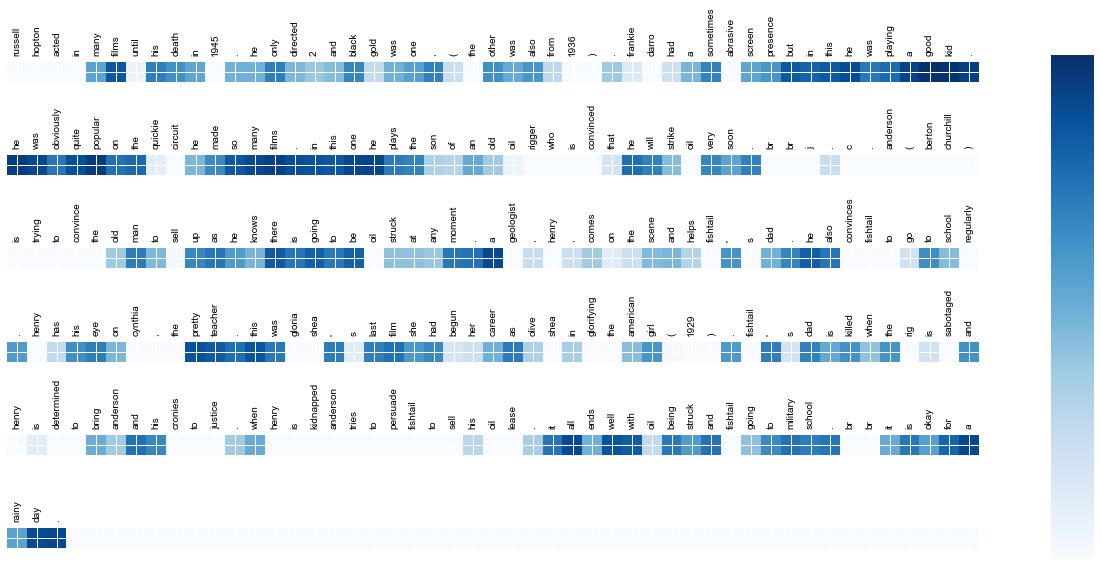

In [25]:
FLAGS = parameters()
# Add model name to ckpt dir
FLAGS.ckpt_dir = FLAGS.ckpt_dir + '/%s'%(FLAGS.model_name)
process_sample_attn(FLAGS)

<a id='11'></a>
### **XI. Attentional History**

Run the cell below and click the play arrow to view the historical attentional scores and learning progression for the same sample as above.

In [26]:
%%HTML
<video width="950" height="500" autoplay loop>
  <source src="images/sample_attention_history.mp4" type="video/mp4">
</video>

You can see how the model starts with equal attention distribution to all words, and then starts to learn which words are important, in order to predict the sentiment. The darker the color, the stronger that particular word is attended to. The first sanity check is that the PAD tokens receive almost no attention; then, we start to see focus on really strong/influential words. Check out a few of the other reviews as well, and you will see that almost always, there is quite a bit of attention at the ends of reviews, which is where people give a concluding statement that summarizes their sentiment succinctly.

We used the sentiment analysis task in order to see how simple it is to add an attentional interface to a model. Though we were able to receive some meaningful attention scores for this task, it is not a trivial task to interpret even with attention. Most reviews (discarding the extremes) will usually talk about the plot for most of the review so it is interesting that we can use attention to pick up on the brief moments of sentiment. An interesting extension of this implementation would be to only use the extreme reviews, where there is a spew of emotion throughout the review.

<a id='12'></a>
### **XII. Attentional Interface Variants**

Our implementation of the soft attentional interface is one of the basic forms of attention, and we can already start to see some interpretability. This is currently a very active area of research where there are developments in different types of tasks using attention (VQA, translation, etc.), different types of attention, and better attentional interface architecture. 

So far, in this article, we have seen how attentional processing can be specialized to the task. With the translation task, the attentional interface is applied to each input word and a summarized context is made for each time step. This is because translation is not always a one-to-one task and a word may depend on several words in the target language for the correct translation. However, for our sentiment analysis implementation, it wouldn't make sense to have a summarizing vector for each input because our output is a binary sentiment. Similarly, there are also processing variants for tasks such as question and answering (ex. pointer-based attention to specific spans in the input) and image-based attention (ex. focusing on different parts of the represented image).

We can also have variants to the architecture of the interface as well. This too is a large, open field of research and we may cover some of the interesting variants in future articles. Here, we’ll introduce one of the architecture variants that is relevant to our sentiment analysis, or any natural language understanding task. 

In the attentional interface we implemented, you may notice that we completely disregard the order of the input review. We processes all of the words in the review, but when we read a review and try to determine the sentiment, it is important to have context for what we have already read. A small tweak in the attentional interface can help us overcome this issue.

![](images/attngru.jpg)
<center><b> Figure 6 </b>[Attention GRU.](http://arxiv.org/abs/1603.01417)</center>
<center>Credit: Goku Mohandas</center>

In order to incorporate order of the input into our attentional interface, all we have to do is first, compute the attention scores for each token in the input. Then, we feed in one token at a time, with the scalar (or vector) attention score in place of the update gate in the GRU. We do this for all tokens in the input and we take the final (relevant output) or all of the outputs -- which of course depends on our task and model architecture. This tweak allows us to incorporate the order of the input, along attentional scores -- giving us both interpretability and a logical architecture.

<a id='13'></a>
### **XIII. Caveats**

As you may notice, this increased interpretability does come with an increased computation cost. This can be a major factor when using these models for production systems, so it is really important to understand the types of tasks these interfaces prove to be really valuable in. For the tasks we talked about here, adding these interfaces really allows us to overcome the information and interpretability bottlenecks. For the specific task of binary sentiment analysis, we can get similar performance with just a bag-of-words model but the model ultimately depends on the performance you are looking for and the computational constraints.

<a id='14'></a>
### **XIV. Interpretability and why it’s important**

As we start to develop increasingly deeper models, it will be important to maintain a high level of interpretability. This becomes more valuable as AI starts to have a greater impact on our everyday lives and we start integrating it everywhere. Attentional interfaces are just the beginning for this field in terms of having transparent models and we need to keep pushing for increased interpretability.

<a id='15'></a>
### **XV. References**
1. Desimone, Robert, and John Duncan. Neural mechanisms of selective visual attention. Annual review of neuroscience 18.1 (1995): 193-222.
2. Kelvin Xu, Jimmy Ba, Ryan Kiros, Kyunghyun Cho, Aaron Courville, Ruslan Salakhutdinov, Richard Zemel: “Show, Attend and Tell: Neural Image Caption Generation with Visual Attention”, 2015; [http://arxiv.org/abs/1502.03044 arXiv:1502.03044].
3. Dzmitry Bahdanau, Kyunghyun Cho: “Neural Machine Translation by Jointly Learning to Align and Translate”, 2014; [http://arxiv.org/abs/1409.0473 arXiv:1409.0473].
4. Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi: “Bidirectional Attention Flow for Machine Comprehension”, 2016; [http://arxiv.org/abs/1611.01603 arXiv:1611.01603].
5. William Chan, Navdeep Jaitly, Quoc V. Le: “Listen, Attend and Spell”, 2015; [http://arxiv.org/abs/1508.01211 arXiv:1508.01211]
6. Karl Moritz Hermann, Tomáš Kočiský, Edward Grefenstette, Lasse Espeholt, Will Kay, Mustafa Suleyman: “Teaching Machines to Read and Comprehend”, 2015; [http://arxiv.org/abs/1506.03340 arXiv:1506.03340].
7. Dzmitry Bahdanau, Kyunghyun Cho: “Neural Machine Translation by Jointly Learning to Align and Translate”, 2014; [http://arxiv.org/abs/1409.0473 arXiv:1409.0473].
8. Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
9. Diederik P. Kingma: “Adam: A Method for Stochastic Optimization”, 2014; [http://arxiv.org/abs/1412.6980 arXiv:1412.6980].
10. Caiming Xiong, Stephen Merity: “Dynamic Memory Networks for Visual and Textual Question Answering”, 2016; [http://arxiv.org/abs/1603.01417 arXiv:1603.01417].

This post is a collaboration between O'Reilly and [TensorFlow](https://www.tensorflow.org/). [See our statement of editorial independence.](http://www.oreilly.com/about/editorial_independence.html)

<a id='16'></a>
### **XVI. Author Bio:**
Goku Mohandas is an artificial intelligence (AI) researcher in Silicon Valley with a focus on using deep learning for natural language tasks. His interests include research on AI for intelligent search and question answering augmented by attentional and memory-based interfaces. He also strongly believes in the democratization of AI with a focus on interpretability and transparency. Previous work includes working on the intersection of AI and biotechnology at the Johns Hopkins University Applied Physics Laboratory.

* Twitter: [@GokuMohandas](https://twitter.com/gokumohandas)
* Github: [ajarai](https://github.com/ajarai)
* Blog: [The Neural Perspective](http://www.theneuralperspective.com)